<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_3/swan3.png" height="300" width="300"> 


# <center> R для тервера и матстата <br>  <br> 8.3 Резкое погружение в финансовый мир с Максимами </center>

Данный ноутбук является конспектом по курсу «R для теории вероятностей и математической статистики» (РАНХиГС, 2019). Автор ноутбука - [вот этот парень по имени Филипп.](https://vk.com/ppilif) Если у вас для него есть деньги, слава или женщины, он от этого всего не откажется. Ноутбук распространяется на условиях лицензии [Creative Commons Attribution-Share Alike 4.0.](https://creativecommons.org/licenses/by-sa/4.0/) При использовании обязательно упоминание автора курса и аффилиации. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу курса.](https://fulyankin.github.io/R_probability/) На ней можно найти другие материалы. Фрагменты кода, включенные в этот notebook, публикуются как [общественное достояние.](https://creativecommons.org/publicdomain/zero/1.0/)

-------------------------------


* Вполне естественный вопрос: "Кто нафиг такой этот Максим, и что он забыл в Финансовом мире?!"

* Спокойно. Сейчас всё расскажу. 

In [2]:
library("ggplot2")  # Пакет для красивых графиков 
library("grid")     # Пакет для субплотов
library("dplyr")    # Куда же без пакета под таблички :) 

# Отрегулируем размер картинок, которые будут выдаваться в нашей тетрадке
library('repr')
options(repr.plot.width=4, repr.plot.height=3)

* Как и в прошлой тетрадке, подгрузим акции. 

In [5]:
library("quantmod")
getSymbols("YNDX", from="2014-01-01", to="2020-01-01")
df = YNDX        # Данные по акциям в таблицу df! 

colnames(df) = c('open', 'high', 'low', 'close', 'volume', 'adjusted')
df$time = 1:nrow(df) # Колонка под время для удобства

df %>% head( )   # Все данные дневные

[1] "YNDX"

            open  high   low close  volume adjusted time
2014-01-02 43.31 43.34 42.36 42.63 1724200    42.63    1
2014-01-03 42.99 43.34 42.63 42.90 1130400    42.90    2
2014-01-06 42.89 43.19 42.61 42.91 1809900    42.91    3
2014-01-07 43.17 43.94 42.06 43.53 2821300    43.53    4
2014-01-08 43.77 44.24 42.22 42.25 3146300    42.25    5
2014-01-09 43.43 45.42 43.17 44.22 5685700    44.22    6

* Возьмём цены закрытия и перейдём к доходностям, гипотезу о нормальности по второму разу тестить не будем. 

In [7]:
price <- as.numeric(df$close)
R = diff(price)/price[-length(price)]

# 1. Хвосты

![](https://sopurrfect.com/wp-content/uploads/2017/10/zachem-koshke-hvost-1170x767.jpg)

## Крайнестан и среднестан 

* В начале курса, когда мы обсуждали ЦПТ, мы говорили, что есть две зоны: __среднестан__ и __крайнестан.__ 

* __Среднестан__ хорош тем, что по нему у нас огромная куча статистики. Случайные величины чаще всего вылезают на нас именно из него, в среднестане мы можем строить хорошие модели 

* __Крайнестан__ очень непредсказуем и опасен. Данные из хвостов на нас выпрыгивают редко. Сложно набрать достаточное количество статистики, чтобы адекватно оценить с какой вероятностью произойдёт катастрофа. Наши оценки постоянно будут занижены. Для работы с крайнестаном нужны свои статистические методы. 

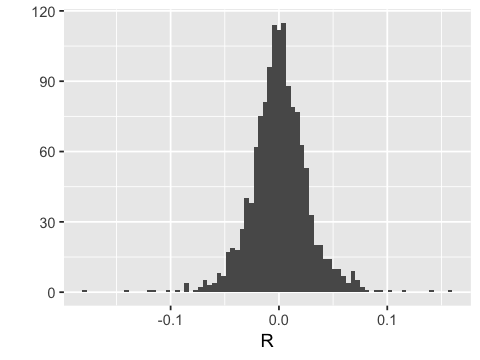

In [9]:
qplot(R, bins=80) 

## Теория экстремальных значений 

* Изучает хвосты распределений, помогает понять какие воздействия выскакивают на нас в экстремальных условиях

* Используется в задачах, где важно смотреть на хвосты (риск-менеджмент, климатология, урбанистика и тп)

* В ней есть куча теории вероятностей, своих тонкостей и разных теорем, на одну из них мы сейчас посмотрим чуть ближе

# 2. Распределение максимумов

Так как наша сверхзадача состоит в моделировании $VaR$ и прочих мер риска, то ключевую роль для нас играют именно экстремальные значения, хвосты распределения. А особенно левый хвост. И мысль здесь следующая: нам не нужно уметь хорошо моделировать все распределение, нам нужно уметь хорошо моделировать только экстремальные события, особенно экстремально плохие события.

Нам нужно будет делить все на блоки, поэтому выкинем последние точки, чтобы лучше делилось. Мы можем делить на блоки произвольной длины, я выберу 20 (в этом будет смысл). А значит я хочу, чтобы массив делился на блоки по 20 нацело.

In [11]:
length(R)

[1] 1369

In [12]:
k <- 20
length(R)/k

[1] 68.45

In [14]:
M <- floor(length(R)/k)
M

[1] 68

In [16]:
R <- R[1:(M*k)]

Моделировать мы будем убытки, поэтому перейдем к ним:

In [18]:
loss <- -R

Теперь пройдем по блокам и в каждом блоке найдем максимальный убыток:

In [32]:
maxs <- rep(0, M)

for (i in 1:M){
  maxs[i] <- max(loss[((i-1)*k+1):(i*k)])
}

maxs

[1] 0.06973328 0.14053333 0.08417085 0.10078685 0.02535900 0.02780891
 [7] 0.06351111 0.03112713 0.05259820 0.04887095 0.04668129 0.11319032
[13] 0.05225917 0.08681130 0.04467960 0.03201635 0.05278732 0.04014791
[19] 0.06135357 0.06683971 0.07538601 0.05163934 0.02322097 0.04394225
[25] 0.05820798 0.07283763 0.06029412 0.05639615 0.02080624 0.03219311
[31] 0.05372617 0.06965868 0.03045231 0.07048059 0.05794393 0.05357143
[37] 0.04810262 0.02872178 0.02242907 0.02933563 0.05536627 0.04716157
[43] 0.04863746 0.03584366 0.03998696 0.04594330 0.03453490 0.03702607
[49] 0.02913534 0.04465065 0.01780684 0.04813410 0.02529324 0.12008122
[55] 0.02753870 0.04162006 0.02823139 0.09209048 0.04130368 0.03865182
[61] 0.17809367 0.04365208 0.03797922 0.02359353 0.08544031 0.03539320
[67] 0.02251311 0.04149165

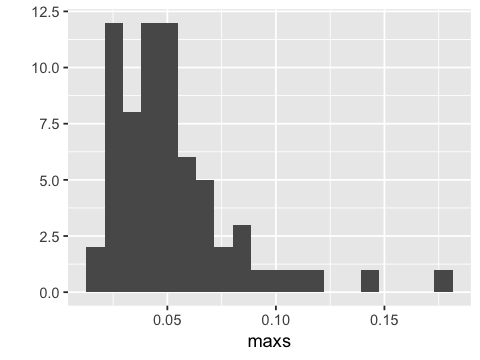

In [33]:
qplot(maxs, bins=20)

В каком-то смысле это распределение $VaR$-ов, так как это распределения худших дней из блоков по $20$. То есть мы взяли блок, выделили в нем максимальную потерю (то есть $5\%$ худших данных) и построили их распределение.

In [34]:
median(maxs)

[1] 0.0463123

In [35]:
quantile(loss, 1-0.05)

95% 
0.04220558

# 3. GEV 

* GEV (Generalized extreme value distribution) - обобщённое распределение экстремальных значений. 

* Распределение опирается на три параметра: среднее $\mu$, дисперсию $\sigma$ и параметр формы $\xi$. Функция распределения у GEV поприятнее, чем у ОГР: 

$$
F(x) = \begin{cases} 
exp(-(1 + \xi \cdot \frac{x - \mu}{\sigma})^{-\frac{1}{\xi}}, \xi \ne 0 \\
exp(-exp(-\frac{x - \mu}{\sigma})), \xi = 0
\end{cases}
$$

* В крайнестане GEV играет роль очень похожую на роль ЦПТ в среднестане. 

* ЦПТ говорила нам о том, как ведёт себя сумма $X_1 + \ldots + X_n$, при $n \to \infty$ (если ни одна из случаынйх величин не выделяется)

* [Теорема Фишера-Типпета-Гнеденко](https://en.wikipedia.org/wiki/Fisher–Tippett–Gnedenko_theorem) говорит нам о том, что максимум из $n$ случайных величин $\cdot \max(X_1, \ldots, X_n)$ при $n \to \infty$ будет вести себя в соответствии с GEV распределением

* Важно, чтобы $X_1, \ldots, X_n \sim iid$

Когда мы говорили с вами о сходимостях случайных величин, мы даже доказали эту сходимость для частного случая. Мы посмотрели к чему будет сходится максимум из $n$ равномерных случайных величин. 

In [39]:
# install.packages("evd")
library("evd")

In [40]:
maxs.fit <- fgev(maxs)
maxs.fit


Call: fgev(x = maxs) 
Deviance: -327.4042 

Estimates
    loc    scale    shape  
0.03855  0.01626  0.23726  

Standard Errors
     loc     scale     shape  
0.002285  0.001824  0.113916  

Optimization Information
  Convergence: successful 
  Function Evaluations: 51 
  Gradient Evaluations: 8 


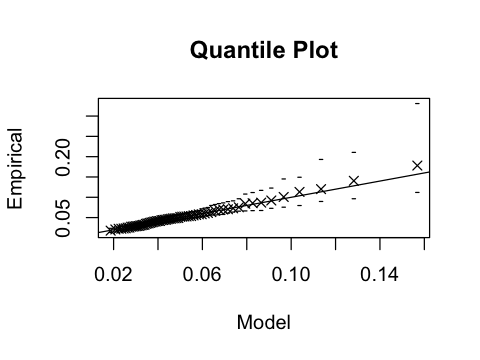

In [46]:
# which это тип картинки
plot(maxs.fit, which=2)

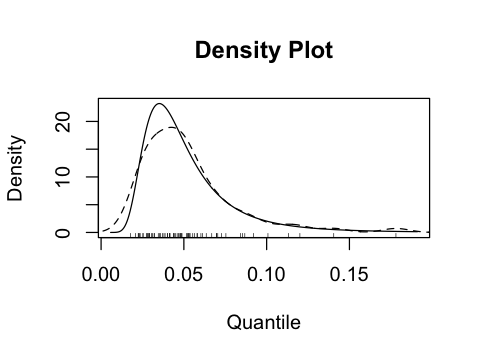

In [45]:
plot(maxs.fit, which=3)

## Новые меры риска

* Так как мы не работаем непосредственно с нашим распределением доходностей, то и говорить прямо о $VaR$ мы не можем. Но можем ввести две новые очень естественные меры.

In [48]:
# среднее значение 
mu <- maxs.fit$estimate[1]
mu

loc 
0.03854917

In [49]:
# разброс
sigma <- maxs.fit$estimate[2]
sigma

scale 
0.01625996

In [50]:
# искажение
xi <- maxs.fit$estimate[3]
xi

shape 
0.2372638

__Мера 1:__ уровень, который будет превзойдён в среднем $1$ раз за $n$ блоков по $k$ наблюдений (квантиль)  

$$
q_{1-\frac{1}{k}} = F^{-1} \left(1-\frac{1}{k} \right) = \mu + \frac{\sigma}{\xi} \cdot \left( \left(-\ln \left(1 - \frac{1}{k} \right) \right)^{-\xi} - 1 \right)
$$

In [52]:
n <- 12
mu + sigma/xi*((-log(1-1/n))^(-xi)-1)

loc 
0.09233541

То есть раз в $12$ блоков по 20 наблюдений мы будем ловить убыток в $9.2\%$. 

__Мера 2:__ среднее время наступления события (математическое ожидание геометрической случайной величины).

$$
\frac{1}{1 - F(BigLoss)}
$$

In [53]:
BigLoss <- 0.2
1/(1-pgev(BigLoss, loc=mu, scale=sigma, shape=xi))

shape 
164.9844

То есть потери в $20\%$ можно ожидать раз в $165$ блоков по $20$ наблюдений, то есть где-то раз в $13$ лет 

In [55]:
20*165/252 # 252 торговых дня в году

[1] 13.09524

# 4. GPD

Вторая интересная идея – моделировать только хвост распределения. Обычно основная проблема заключается в том, что мы не дооцениваем то, что происходит в хвосте из-за нехватки экстремальных данных. Можно попробовать моделировать хвосты с помощью [обобщённого распределения Парето, GPD.](https://en.wikipedia.org/wiki/Generalized_Pareto_distribution)

Функция распределения будет в этом случае выглядеть как 

$$
F_{GPD}(x) = \begin{cases}
1 - \left(1+ \frac{\xi(x-\mu)}{\sigma}\right)^{-1/\xi} & \text{for }\xi \neq 0, \\
1 - \exp \left(-\frac{x-\mu}{\sigma}\right) & \text{for }\xi = 0.
\end{cases}
$$

Пусть случайная величина $X$ распределена с функцией распределения $F(x)$. Нас интересуют её значения, превышающие некоторый порог $u$, то есть значения из хвоста. Интересно было бы посмотреть как именно будут распределены такие значения. Чтобы найти функцию распределения, нужно воспользоваться формулой условной вероятности: 

$$
F_u(x) = P(X - U \le x \mid X > U) = \frac{F(x + u) - F(u)}{1 - F(u)} 
$$

[Теорема Пикандса-Балкема-де Хаана](https://en.wikipedia.org/wiki/Pickands–Balkema–de_Haan_theorem) говорит, что 

$$
\sup_{x \in \mathbb{R}} \mid \hat F_u(x) - F_{GPD}(x) \mid \overset{\text{п.н.}}{\to} 0.
$$

Иначе говоря, эта теорема разрешает нам моделировать хвосты отдельно при большом числе наблюдений и высоком значении порога. 

Будем моделировать худшие $10\%$ доходностей. 

In [170]:
# Выставляем порог и находим пороговое значение
th = 0.1
u = quantile(loss, 1-th, names = FALSE)

GPD.fit = fpot(loss, threshold = u, model = "gpd")
GPD.fit


Call: fpot(x = loss, threshold = u, model = "gpd") 
Deviance: -833.0356 

Threshold: 0.0308 
Number Above: 136 
Proportion Above: 0.1 

Estimates
  scale    shape  
0.01435  0.18258  

Standard Errors
   scale     shape  
0.001871  0.101231  

Optimization Information
  Convergence: successful 
  Function Evaluations: 40 
  Gradient Evaluations: 6 


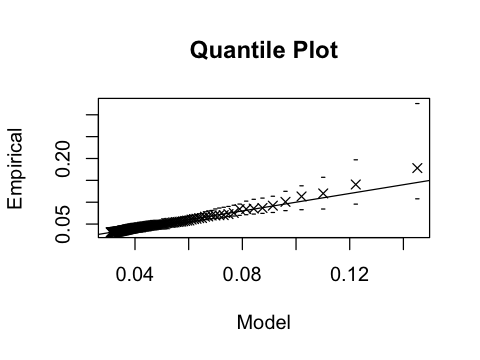

In [171]:
plot(GPD.fit, which = 2)

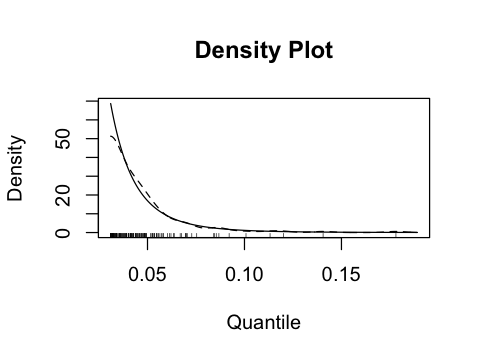

In [172]:
plot(GPD.fit, which = 3)

Дело за малым, [найти VaR.](https://www.rdocumentation.org/packages/SpatialExtremes/versions/2.0-7/topics/Generalized%20Pareto%20Distribution) Формулу для его поиска можно по-честному найти из функции распределения. Либо подсмотреть [тут.](https://pdfs.semanticscholar.org/0370/690046e78892402385887d04f1d9af2e5bb5.pdf) Там же можно найти формулу для ES.

In [207]:
scale <- GPD.fit$estimate[1]
xi <- GPD.fit$estimate[2]

alpha = 0.05
VaR <- scale/xi*((th/alpha)^xi - 1) + u
-VaR

scale 
-0.04143127

In [209]:
ES <- (VaR + sigma - xi*u)/(1 - xi)
-ES

scale 
-0.06135045

## Резюме

* Распределение максимумов сходится к GEV, с помощью него можно попытаться смоделировать их
* Превышение некоторого порога $u$ сходится к GPD, мы можем отсечь у распределения какой-то процент плохих случаев и попытаться замоделировать его

## Авторские права и почиташки 

В основе этой тетрадки (вплоть до копипасты) лежит [курс моего друга, Ильи Езепова](https://rpubs.com/iezepov) по рискам и всяким другим прикольным штукам в R. Для того, чтобы успешно его освоить, надо уметь хорошо проверять гипотезы, а также немного подучить эконометрику. 

Вы смело можете попробовать ознакомиться с ним. 

* [Лекция 1 - вводная](https://rpubs.com/iezepov/e502lec1)
* [Лекция 2 - кривая VaR, пакет ghyp и Монте-Карло](https://rpubs.com/iezepov/e502lec2)
* [Лекция 3 - разговоры о волатильности, GARCH и ARCH модели. ](https://rpubs.com/iezepov/e502lec3)
* [Лекция 4 - инвестируем в портфель и изучаем копулы.](https://rpubs.com/iezepov/e502lec4)
* [Лекция 5 - много разных картинок.](https://rpubs.com/iezepov/e502lec5)
* [Лекция 6 - моделирование хвостов и непараметрические оценки.](https://rpubs.com/iezepov/e502lec6)
* [Лекция 7 - PCA, факторный анализ, кластеризация и многое другое.](https://rpubs.com/iezepov/e502lec7)
* [Лекция 8 - Временные ряды и панельные данные в R](https://rpubs.com/iezepov/e502lec8) 

Пусть ссылки на все эти лекции лежат тут. Когда вы морально будете готовы вникнуть в них, читайте! :) Кстатит говоря, если хотите погрузится в финансовый мир не так резко, как мы это сделали сегодня, прочтите [книгу Кванты](https://yadi.sk/i/ryFfPZ8_1uTO6g) и книгу [Хулиганская экономика.](https://yadi.sk/i/dpNfMQNSQexUTg) Пацаны очень чётко в них всё расписывают. Такой научпоп сойдёт за курс введения в финансы.

* Если есть желание почитать серьёзный учебник, подойдёт [вот эта книга.](https://yadi.sk/i/B2wAalCi_kNpDg) Вся 7 глава в ней описывает теорию экстремальных значений. 
* [Небольшой холивар Талеба и Пинкера о войнах и тяжёлых хвостах](https://newochem.ru/politika/neuzhto-stalo-menshe-vojn/)

![](https://i.pinimg.com/736x/f6/3a/d3/f63ad308f4a2073def67c5dbb4f701bb--earth-raccoons.jpg)